<a href="https://colab.research.google.com/github/jemappellelisa/datasciencecoursera/blob/master/KerasBasics_CondMat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief Introduction: Deep Learning with Keras

In [0]:
# Tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# To use GPU/TPU, go to Edit -> Notebook Settings -> select GPU
# GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)

Found GPU at: /device:GPU:0
1.12.0


In [0]:
# Temporarily clone the github with data and some auxiliary files
!git clone https://github.com/fiscioluzzi/ml_for_exp_condmat_workshop
  
# Import some additional helper methods
import ml_for_exp_condmat_workshop.Ising.util as util

Cloning into 'ml_for_exp_condmat_workshop'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 109 (delta 8), reused 4 (delta 1), pack-reused 85
Receiving objects: 100% (109/109), 25.07 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (40/40), done.


# Example 1: Ising Spin Configuration Classification

To get acquainted with the basic elements of Keras, we will train a simple neural network to classify the ferromagnetic versus the paramagnetic phase of the Ising model. 

The Ising model is given by the (classical) Hamiltonian:

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{<ij>} \sigma_{i}\sigma_{j},
\end{align}
where the spins $\sigma_{i} \in \lbrace -1, 1 \rbrace$ are binary variables living on the vertices of a square lattice and the sum is taken over nearest neighbours $<ij>$. 
  
At a given temperature $\beta = 1/T$, the probability of a configuration $\sigma$ is given by the Boltzmann distribution
  
\begin{align}
  P(\boldsymbol{\sigma}) = \frac{e^{-\beta H(\boldsymbol{\sigma})}}{Z},
 \end{align}
  
  where $Z$ is the partition function. This model exhibits a phase transition from the ferromagnetic phase at low tempertures to a paramagnetic phase at high temperatures. The transition temperature is $T_c \approx 2.2692$.
  
  **Task**
 
1.   Classify the ferromagnetic versus the paramagnetic phase of the Ising model
2.   Find the transition temperature
  
**Dataset**: Monte Carlo generated configurations on a 30x30 square lattice. The configuration are labelled by temperature.


## Step 1. Import the dataset

All the data files necessary for this notebook are available from the git repository we cloned above (https://github.com/fiscioluzzi/ml_for_exp_condmat_workshop). There's also python scripts that perform (semi-) basic Monte Carlo to generate such configurations.

In [0]:
N = 30 # linear dimension of the lattice 

ising_training_configs = np.load("ml_for_exp_condmat_workshop/Ising/ising_training_configs_{0}x{0}.npy".format(N))
ising_training_labels = np.load("ml_for_exp_condmat_workshop/Ising/ising_training_labels_{0}x{0}.npy".format(N))
ising_test_configs = np.load("ml_for_exp_condmat_workshop/Ising/ising_test_configs_{0}x{0}.npy".format(N))
ising_test_labels = np.load("ml_for_exp_condmat_workshop/Ising/ising_test_labels_{0}x{0}.npy".format(N))



print('train_images.shape =', ising_training_configs.shape)
print('train_labels.shape =', ising_training_labels.shape)
print('test_images.shape =', ising_test_configs.shape)
print('test_labels.shape =', ising_test_labels.shape)

train_images.shape = (1000, 30, 30)
train_labels.shape = (1000,)
test_images.shape = (1000, 30, 30)
test_labels.shape = (1000,)


We see that we have a training set of size 1000 and a test set of size 1000, too (This is of course not that much data). 

Each image is a 30x30 array which takes values in {-1, 1}. The labels of these images are the temperatures and they are in [1, 3.5]. Let us plot some of these images to see what we are dealing with.

In [0]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
util.plot_Ising_configuration(ising_training_configs[250], ax1)
util.plot_Ising_configuration(ising_training_configs[500], ax2)
util.plot_Ising_configuration(ising_training_configs[900], ax3)
ax1.set_title("T={:1.2f}".format(ising_training_labels[250]))
ax1.title.set_position((0.5,-0.1))
ax2.set_title("T={:1.2f}".format(ising_training_labels[500]))
ax2.title.set_position((0.5,-0.1))
ax3.set_title("T={:1.2f}".format(ising_training_labels[900]))
ax3.title.set_position((0.5,-0.1))

NameError: ignored

Before we employ ML to classify the spin configurations, we can use some more standard methods to see potential structure in the data. In the following, we use a principal component analysis (PCA) to do just that.

In [0]:
def pca(X=np.array([]), no_dims=50):
    """
          Runs PCA on the NxD array X to reduce dimension
    """
    (n, d) = X.shape
    # Make each pixel have zero mean
    X = X - np.tile(np.mean(X, 0), (n, 1))
    
    # Diagonalise the covariance matrix
    (l, M) = np.linalg.eig(np.dot(X.T, X)) 
    
    Y = np.dot(X, M[:, :no_dims])
    return Y

In [0]:
PCA_coord = pca(np.reshape(np.array(ising_training_configs),(ising_training_configs.shape[0], 900)), no_dims=2)

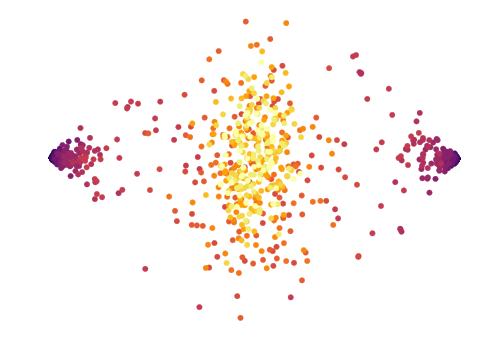

In [0]:

plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(PCA_coord[:,0], PCA_coord[:,1], 30, ising_training_labels, 
            cmap=plt.get_cmap('inferno'))
plt.axis('off')
plt.show()

Clearly, even this simple analysis manages to see that there are three distinct sets of data: the two fully polarized extremes are on the right and left, and the paramagnetic phase in the middle.

In the following, we will use a simple model to distinguish the ferromagnetic vs. the paramagnetic phase using a dense neural network.

Before setting up the model, we need to prepare the data. At the moment, our configurations are labelled by their temperature. Since we want to learn to classify the two phases, we need to label our data by 'Ordered' (label=0) vs 'Disordered (label=1). 

Let us assume that we know $1.5=T_{low}<T_{c}< T_{high} = 2.5$. Then we exclude all the data between $T_{low}$ and $T_{high}$. We label all configurations below $T_{low}$ with '0' and all those above $T_{high}$ with '1'.



In [0]:
T_low = 1.5
T_high = 2.5
train_images = []
train_labels = []
for i, label in enumerate(ising_training_labels):
    if label < T_low:
        train_images.append(ising_training_configs[i])
        train_labels.append(0)
    if label > T_high:
        train_images.append(ising_training_configs[i])
        train_labels.append(1)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [0]:
test_images = []
test_labels = []
for i, label in enumerate(ising_test_labels):
    if label < T_low:
        test_images.append(ising_test_configs[i])
        test_labels.append(0)
    if label > T_high:
        test_images.append(ising_test_configs[i])
        test_labels.append(1)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Step 2. Setup the model

Specifications of our model: 

*  Our model takes in a 30 by 30 array
*  And outputs a 2-dimensional vector

The 2-dimensional vector gives the models prediction for whether the system is ferromagnetic (i.e., T < Tc) or paramagnetic (T>Tc).

The model's prediction is given by the index with the largest value, i.e. argmax(output)

There are two ways to create models within Keras.

1.   Sequential Model
2.   Model class with the functional API

In both methods, the basic building block is the layer. A layer takes some input tensor and applies some transformation and returns an output tensor.

First let us explore the sequential model.


### Sequential Model
This model is basically a linear stack of layers. 
Check out the keras documentation for more information about layers and activation functions:
https://keras.io/layers/core/, https://keras.io/activations/

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(30, 30)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# or equivalently
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(30, 30)))
model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dense(2, activation=tf.nn.softmax))

# We can also print a summary of our model by
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                28832     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________


### The Keras Model class

Another method for building our model is to use the Keras functional API. For simple (linear) models, the Sequential method is definitely more convenient. But the functional API is useful when we want to have a  model with multiple inputs/outputs or models with shared layers. More information about the functional API can be found at https://keras.io/getting-started/functional-api-guide/

In [0]:
# We first need to instantiate the input tensor
x = keras.layers.Input(shape=(30,30))

# Then we apply layers to the input tensor which returns another tensor 
# and then the next layer and so on
f = keras.layers.Flatten()(x)
h = keras.layers.Dense(32, activation=tf.nn.relu)(f)
y = keras.layers.Dense(2, activation=tf.nn.softmax)(h)

# Define the model by the input and output tensors
model = keras.models.Model(inputs = x, outputs =y)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 30)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                28832     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________


Look here for information other layers available in keras https://keras.io/layers/core/

## Step 3. Compile the model
Now that the model is defined, we need to train our model. But before doing so, there are a few details we need to specify.


1.   Loss function: we need to choose what function we want our model to minimise e.g. mean square error or cross entropy or ...
2.   Optimisation method: How we want to update the weights e.g. stochastic gradient descent or ADAM or ...
3.   Metrics: some quantity we want to keep track off while we are training, e.g. value of the loss function or the accuracy of the model...

One could also choose other loss functions or optimisers: https://keras.io/losses/, https://keras.io/optimizers/



In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 

## Step 4. Train the model

Finally we are ready to train our model. Here we basically just need to feed the data set to our model, and the model would minimise the loss function we chose and update the model parameters according to the optimisation method we specified. 

The last thing we need to choose is the number of epochs and the batch_size.


*   batch_size: this is the number of images we feed to our model in 1 iteration
*   epochs: the number of times we run through our data set.

Let's suppose batch size = 100. Then the training proceeds as follows: 

1.   Divide our dataset in batches of 100. 
2.   Take a batch of 100 samples and feed it to the model. This gives 100 output vectors from which we compute the loss function and its gradient w.r.t. to model parameters.
3. Use the gradients to update the model parameters according to the optimiser we chose 
4. Repeat steps 2 and 3 until we have cycled through to the end of the dataset. This will be the end of one epoch.

Number of iterations in one epoch = size of data set / batch_size


A few comments:

* The smaller the batch size, the faster the model trains.
* The smaller the batch size, the more noisy the training will be.
* Some amount of noise is useful to prevent us from getting stucked in local minima.





In [0]:
model.fit(train_images, train_labels, epochs = 10, batch_size = 16, validation_data=(test_images,test_labels))

Train on 600 samples, validate on 600 samples
Epoch 1/10
600/600 [==============================] - 1s 1ms/step - loss: 0.4145 - acc: 0.8133 - val_loss: 0.3168 - val_acc: 0.8483
Epoch 2/10
600/600 [==============================] - 0s 365us/step - loss: 0.0329 - acc: 1.0000 - val_loss: 0.2137 - val_acc: 0.9017
Epoch 3/10
600/600 [==============================] - 0s 358us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.1868 - val_acc: 0.9200
Epoch 4/10
600/600 [==============================] - 0s 354us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.1703 - val_acc: 0.9317
Epoch 5/10
600/600 [==============================] - 0s 364us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.1582 - val_acc: 0.9350
Epoch 6/10
600/600 [==============================] - 0s 400us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1475 - val_acc: 0.9400
Epoch 7/10
600/600 [==============================] - 0s 390us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.1394 - val_acc: 0.9433
Epoch 8/10
600/600

## Step 5. Evaluate our model
Now that our model is trained, we can test our model on the configurations we have not yet seen (ising_test_configs). 

In [0]:
loss, acc = model.evaluate(test_images, test_labels)

print('loss on test set =', loss)
print('accuracy on test set =', acc)

600/600 [==============================] - 0s 85us/step
loss on test set = 0.12331651519052685
accuracy on test set = 0.9483333333333334


We can also get the output of our model on individual configurations using the predict method.
We can then use this output to see where the model would predict Tc to be.

In [0]:
prediction = model.predict(ising_test_configs)
print(prediction)

[[9.9932611e-01 6.7389052e-04]
 [9.9951673e-01 4.8332772e-04]
 [9.9939895e-01 6.0104515e-04]
 ...
 [3.3391601e-01 6.6608399e-01]
 [1.8908046e-02 9.8109198e-01]
 [1.0982205e-01 8.9017797e-01]]


To evaluate where the model predicts Tc to be, we average the prediction for all the configurations for a given temperature. 

We also calculate the absolute value of the magnetization ($m=|\sum \sigma_i|$) for comparison, since we know that this is our order parameter.

In [0]:
Temps = list(np.sort(list(set(ising_test_labels))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(ising_test_labels):
    j = Temps.index(T)
    phase1[j]+=prediction[i:i+1, 0][0]
    phase2[j]+=prediction[i:i+1, 1][0]
    m[j] += abs(np.mean(ising_test_configs[i]))
    points[j]+=1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]

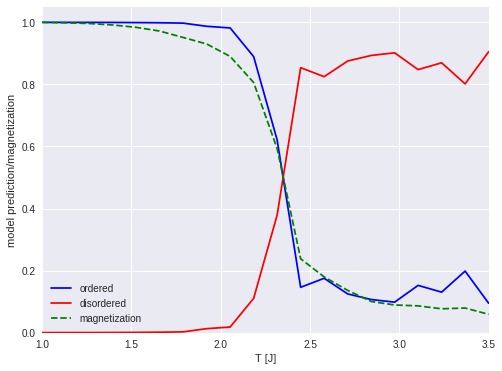

In [0]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(Temps, phase1, 'b', label='ordered')
plt.plot(Temps, phase2, 'r', label='disordered')
plt.plot(Temps, m, 'g--', label="magnetization")
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(1,3.5)
plt.xlabel('T [J]')
plt.ylabel('model prediction/magnetization')
plt.show()

We can now estimate the location of the transition. Lets define this to be the location where our model's prediction drops to $0.5$.

In [0]:
index = (np.abs(phase1 - 0.5)).argmin()
tc = Temps[index]

print("Estimated Transition Temp =", tc)

Estimated Transition Temp = 2.3157894736842106


The exact transition temperature in the thermodynamic limit is $2.2692$, so our result is not so bad considering finite size effects. If we look again at the above plot, we can see that the curves coincide relatively nicely with the average magnetization, this suggest that the network is indeed learning the magnetization, i.e. it is computing the magnetization and using it to make its prediction.

## Learning by Confusion

There is also another way one can discover the transition point https://arxiv.org/abs/1610.02048. 

Here we simply guess the transition temperature. Let's say we guess it to be $T_{p}$, then we take our dataset and label it according to:
*   $T < T_{p}$: 'Ordered' 
*   $T > T_{p}$: 'Disordered'

We train our network and obtain some accuracy on our test set.

As we vary this 'guess' temperature, the final test set accuracy would vary. The idea is that the accuracy would be high when this guess $T_{p}$ is close to the correct transition temperature $T_{c}$. In other words, if we plot accuracy versus our guess $T_{p}$, we should see a local maxima around $T_{c}$.


In [0]:
Tp = list(set(ising_test_labels))
Tp.sort()
accuracies = []

train_images = ising_training_configs
test_images = ising_test_configs

for tp in Tp:
  # Label training set
  train_labels = []
  for i, label in enumerate(ising_training_labels):
      if label <= tp:
          train_labels.append(1)
      else:
          train_labels.append(0)
  train_labels = np.array(train_labels)
  
  # Label test set
  test_labels = []
  for i, label in enumerate(ising_test_labels):
      if label <= tp:
          test_labels.append(1)
      else:
          test_labels.append(0)
  test_labels = np.array(test_labels)
  
  # Define our model
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(30, 30)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
  ])
  
  # Compile our model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 
  
  # Train
  model.fit(train_images, train_labels, epochs = 10, batch_size = 16, verbose=0)
  
  # Evaluate and save accuracy
  loss, acc = model.evaluate(test_images, test_labels, verbose=0)
  accuracies.append(acc)
  
  print("Tp = {:.2f}".format(tp))

Tp = 1.00
Tp = 1.13
Tp = 1.26
Tp = 1.39
Tp = 1.53
Tp = 1.66
Tp = 1.79
Tp = 1.92
Tp = 2.05
Tp = 2.18
Tp = 2.32
Tp = 2.45
Tp = 2.58
Tp = 2.71
Tp = 2.84
Tp = 2.97
Tp = 3.11
Tp = 3.24
Tp = 3.37
Tp = 3.50


Text(0.5,0,'Temp')

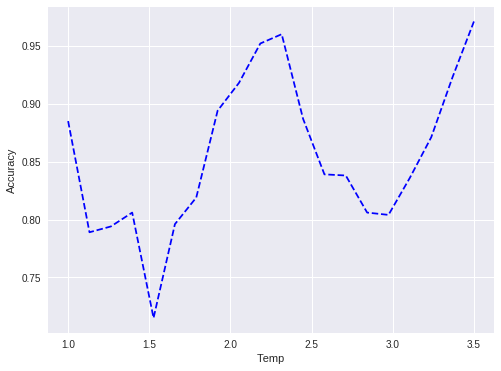

In [0]:
plt.plot(Tp, accuracies,'b--')
plt.ylabel('Accuracy')
plt.xlabel('Temp')

We can indeed see a peak in the accuracy somewhere around $T=2.3$, close to where we expect the transition to take place.

## Summary



1.   Load our data set. These are simply numpy arrays of shape (number of samples, configuration shape)
2.   Preprocess the data if necessary, e.g. rescaling the configuration 'pixels' to take values between 0 and 1 or some suitable values. 
3.   Define the model.
4.   Compile the model: Choose your desired optimiser.
5.   Train the model.



# Example 2: A Slightly Harder Dataset: Ising model with local constraint.

In the previous example, we classified spin configurations of the simple Ising model. That was a relatively easy task given that we know that there's a global order paramter, i.e., the magnetization that distinguishes the two phases the model has.

In the following, we will look at spin configurations coming from a different model on which the dense neural network spectacularly fails. In this model, Ising spins live on the edges of a square lattice (see Figs. below). The Hamiltonian then favors even down and up spins around a square. If the number is odd, a pentalty is paid. The Hamiltonian is given by

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{p} \prod_{i \in p}\sigma_{i},
\end{align}
where we sum over the plaquettes $p$ of the square lattice.

This model does not have a finite temperature transition. We thus want to train a network to distinguish the (highly degenerate) ground states of this system from any excited state.

## Locally constraint Hamiltonian

We now look at a lattice with linear dimension N=16 and. Note that since there are two spins per unit cell (one on the x, one on the y bond), our configurations have shape NxNx2.
             

In [0]:
N = 16 # linear dimension of the lattice 

ilgt_training_configs = np.load("ml_for_exp_condmat_workshop/Ising/ilgt_training_configs.npy".format(N))
ilgt_training_labels = np.load("ml_for_exp_condmat_workshop/Ising/ilgt_training_labels.npy".format(N))
ilgt_test_configs = np.load("ml_for_exp_condmat_workshop/Ising/ilgt_test_configs.npy".format(N))
ilgt_test_labels = np.load("ml_for_exp_condmat_workshop/Ising/ilgt_test_labels.npy".format(N))



print('train_images.shape =', ilgt_training_configs.shape)
print('train_labels.shape =', ilgt_training_labels.shape)
print('test_images.shape =', ilgt_test_configs.shape)
print('test_labels.shape =', ilgt_test_labels.shape)

train_images.shape = (2000, 16, 16, 2)
train_labels.shape = (2000,)
test_images.shape = (2000, 16, 16, 2)
test_labels.shape = (2000,)


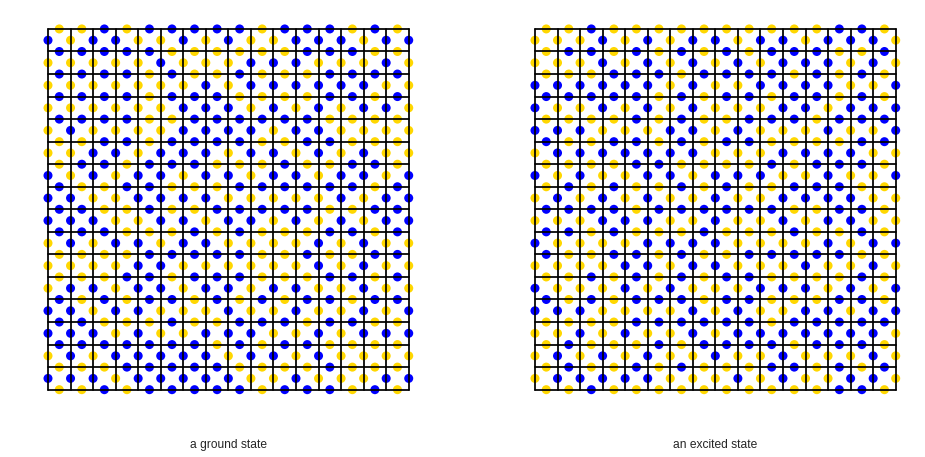

In [0]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
util.plot_ILGT_configuration(ilgt_training_configs[0], ax=ax1)
util.plot_ILGT_configuration(ilgt_training_configs[-1], ax=ax2)
ax1.set_title("a ground state")
ax1.title.set_position((0.5,-0.1))
ax2.set_title("an excited state")
ax2.title.set_position((0.5,-0.1))


Simply looking at these configurations, it seems not obvious how to distinguish them. Let's first again see what PCA tells us:

In [0]:
PCA_coord_ILGT = pca(np.reshape(ilgt_training_configs, (ilgt_training_configs.shape[0], N*N*2)), no_dims=2)

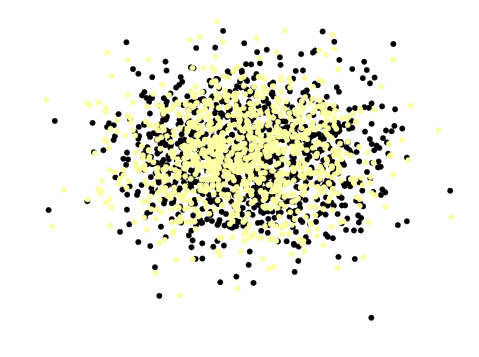

In [0]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(PCA_coord_ILGT[:,0], PCA_coord_ILGT[:,1], 30, ilgt_training_labels, 
            cmap=plt.get_cmap('inferno'))
plt.axis('off')
plt.show()

Here, PCA seems to be of not that much help. 

Note that while we will not give the following information to the neural network, we know how these configurations can be easily distinguished. First, we change to a dual picture of the spins on the bonds, where we draw a line through the bond if there is an up spin there, but not if there's a down spin. Having all constraints fulfilled then simply corresponds to having only closed loops (always two or four lines at a center of a square).

Let us examine how this looks like if we introduce a single defect:

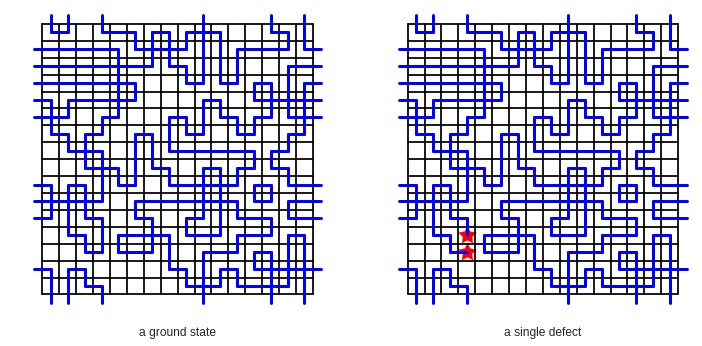

In [0]:
single_excitation = ilgt_training_configs[0].copy()
# location of our single defect:
i = 3
j = 2
# this will introduce the defect:
single_excitation[i, j, 1]*=-1

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
util.plot_ILGT_configuration(ilgt_training_configs[0], dual=True, ax=ax1)
util.plot_ILGT_configuration(single_excitation, dual=True, ax=ax2)
ax1.set_title("a ground state")
ax1.title.set_position((0.5,-0.1))
ax2.set_title("a single defect")
ax2.title.set_position((0.5,-0.1))



## Define our models.

For this example, we want to compare the performance of two models:


1.   The Dense network exactly as we defined for the simple Ising model
2.   Dense Network with dropout layers.
3.   A deep convolutional network

### Dense Network

In [0]:
# Dense network
dense = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 16, 2)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# Compile the model with an optimiser
dense.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','sparse_categorical_crossentropy']) 

# Print a summary of the model
dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 51,502
Trainable params: 51,502
Non-trainable params: 0
_________________________________________________________________


### Dense Network with dropout

In [0]:
# Dense network
dense_dropout = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 16, 2)),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

# Compile the model with an optimiser
dense_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','sparse_categorical_crossentropy']) 

# Print a summary of the model
dense_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 202       
Total params: 51,502
Trainable params: 51,502
Non-trainable params: 0
_________________________________________________________________


### Convolutional Network

We use the following very simple architecture:

Conv --> Dense -->Dropout --> Output

In [0]:
# we want to be able to use different kernel sizes and compare
def convolutional_model(kernel_size):
    input_size = 16+2*(kernel_size-1)
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(16, (kernel_size, kernel_size), strides=(1,1), padding='Valid', input_shape=(input_size,input_size,2), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy','sparse_categorical_crossentropy'])
    
    return model

In [0]:
kernel_size = 2
model = convolutional_model(kernel_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 17, 17, 16)        144       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4624)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 37000     
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 37,162
Trainable params: 37,162
Non-trainable params: 0
_________________________________________________________________


We have introduced here two new layers. Lets briefly understand what each layer does.

1.  **Convolutional**: This layer applies 32 kernels of size 2 by 2 over the input image. There are 2 paddings one can choose from 'valid' or 'same'. For our purpose, we need periodic boundary conditions and we thus use 'Valid', which means it does not add additional 'pixels' around the configuration. We instead add the padding ourselves (see below).
```
 keras.layers.Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding = 'Valid', activation=tf.nn.relu)
```


2.  **Dropout**: This layers drops the nodes in the layer above with a 50% probability.
```
keras.layers.Dropout(0.5)
```
Note that this layer is only applied during training. When evaluating or predicting on test samples, this layer is not applied.

For more information about layer check out the keras documentation: https://keras.io/layers/about-keras-layers/


One final note on the input shape: While for the (first) dense layer we can define just about any shape, the input shape for the convolutional layer is necessarily N x M x C, where C is the number of channels. If the input available has only a single channel, i.e., its shape is N x M, an additional axis with dimension 1 needs to be added for it to work.

## Training

Now we can train our models. This is exactly the same as before but this time we include some validation data. That is after each epoch, we evaluate our model on a validation set (this is just the test set for our case).

In [0]:
# Dense
dense_history = dense.fit(ilgt_training_configs, ilgt_training_labels, epochs = 50, 
                          validation_data=(ilgt_test_configs, ilgt_test_labels), 
                          batch_size = 32, verbose = 0)

In [0]:
# Dense with dropout
dropout_history = dense_dropout.fit(ilgt_training_configs, ilgt_training_labels, epochs = 50, 
                          validation_data=(ilgt_test_configs, ilgt_test_labels), 
                          batch_size = 64, verbose = 0)

Before we can train the convolutional network, we need to add the periodic padding. This is done here with a helper function we loaded above.

In [0]:
# Create the periodic padding for training and test configurations
x_n = util.create_periodic_padding(ilgt_training_configs,kernel_size)
test_x_n = util.create_periodic_padding(ilgt_test_configs, kernel_size)

In [0]:
convolutional_history = model.fit(x_n,ilgt_training_labels,epochs=50, 
                                  validation_data=(test_x_n, ilgt_test_labels), 
                                  batch_size=32, verbose=0)

## Test our models.


In [0]:
# Dense Network
loss,acc,_ = dense.evaluate(ilgt_test_configs, ilgt_test_labels)

print('Dense Network')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

2000/2000 [==============================] - 0s 72us/step
Dense Network
loss on test set = 1.9547066679000855
accuracy on test set = 49.65%


In [0]:
# Dense Network
loss,acc,_ = dense_dropout.evaluate(ilgt_test_configs, ilgt_test_labels)

print('Dense Network with dropout')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

2000/2000 [==============================] - 0s 76us/step
Dense Network with dropout
loss on test set = 1.922369906425476
accuracy on test set = 49.45%


In [0]:
# Convolutional Network
loss, acc, _ = model.evaluate(test_x_n, ilgt_test_labels, verbose=0)
print('Convolutional Network with dropout')
print('loss on test set =', loss)
print('accuracy on test set = {}%'.format(acc*100))

Convolutional Network with dropout
loss on test set = 0.0001872577452486439
accuracy on test set = 100.0%


We can see quite nicely that although the two networks have a similar number of parameters, the convolutional network has substantially better performance. Of course they also train substantially slower, and one might think: "Why dont we just use an even larger dense network?". The problem with using more and more parameter is that it becomes easier for the model to overfit the training data, i.e. instead of learning relevant features, the network is simply memorising the data. This is problem because it means that it would not perform very on data it has not seen which is the main aim of training these networks for classification tasks.

## Overfitting

If we look at the accuracies of our models evaluated on the training set vs test set. We can already see that there is some overfitting ()very severe here), i.e. we have a much higher accuracy on the training set compared to the test set. We can see this more clearly if we plot some statistics which were stored during the training.

In [0]:
def plot_history(histories, key='sparse_categorical_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

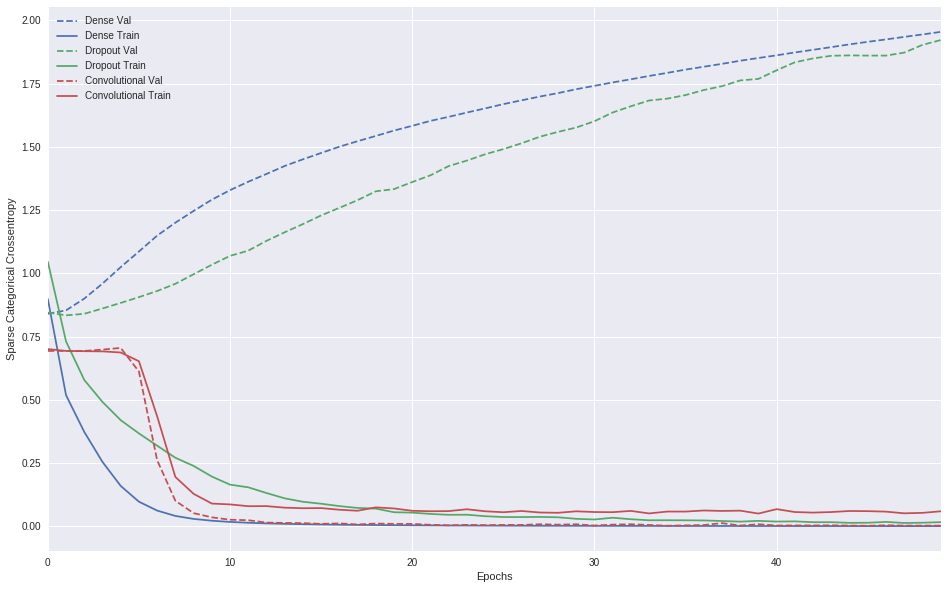

In [0]:
plot_history([('Dense',dense_history),
              ('Dropout', dropout_history),
              ('Convolutional', convolutional_history)])

From the above plot, we can observe a few things. 

1.  **Dense Network (Blue**):  Very quickly, the loss is decreasing on the training set, but it is actually increasing for the validation set. There is a large and widening gap between validation loss and training loss.  (We are overfitting)
2. **Dense Network with dropout (green)**  By adding a dropout layer, one can see that the gap between the training and validation loss is smaller. For many applications, adding a dropout layer can help avoiding overfitting. This is, however, not enough here.
2.   **Convolutional Network (Red)**: Both the validation and the training losses are decreasing for all epochs (No overfitting).
3. Even though the dense network has a lower loss on the training set, the loss on the validation set is much higher than the convolutional network.

We can see that the dropout layer is definitely helps to prevent the overfitting.

Some ways to combat overfitting:

1. **Dropout layers**: This prevents the model from co-adapting or memorising data
2. **Adding regularisation** terms to cost function, e.g. to penalise large parameters: This limits the power of the model by preventing it from exploring large parameters, e.g.
```
l2_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.softmax)
])
```
This would add a L2 regularisation term to the loss function, i.e. L2 = ||w||^2 where w represents the weights of the corresponding layer.


3. **Early stopping**: Here we simply stop training when we have achieved a satisfactory validation accuracy or loss. For example, in the dense network we trained above, it is probably a good idea to stop the training after aroud 11 epochs.



# Summary

1.   Keras basics: create models, train models, evaluate models.
2.   Large models trained without regularisation is prone to overfitting.
3.   Dropout layers can help combat overfitting
4.   Convolutional networks are usually better than dense networks for image classification, or generally problems with some degree of 'translational invariance'.
